In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from modeling import optimize
from itertools import product
np.random.seed(42)

In [27]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

In [28]:
df.age.describe()

count    899.000000
mean      53.480534
std        9.435894
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: float64

`types` is a dataframe containing all features available on the dataset and a respective feature type belonging to one of the following:
- `G` - Genetic/Intrinsic feature (uncontrollable fetures like sex and age)
- `E` - Environmental/Behavioural feature (features that can be controlled, even if slightly, like blood sugar and smoking)
- `H` - Information based on medical history (purely historical information, like previous episodes of chest pain)
- `T` - Test result (tests that require any kind of medical equipment like blood pressure monitors)
- `TP` - Test parameter (condition under which a test has been conducted)
- `CT` - "Cheap" test (tests or checks that can be performed without specific medical equipment)

In [29]:
types = pd.read_csv('data/processed/feature_types.csv').dropna()

In [30]:
for group in types.groupby('feature_type').groups:
    print(types.groupby('feature_type').get_group(group))
    print()

               feature feature_type
33  blood_press_s_rest           CT
48     heart_rate_peak           CT
49     heart_rate_rest           CT
53           ex_angina           CT

                feature feature_type
34                 chol            E
35               smoker            E
36  smoker_cigs_per_day            E
37         smoker_years            E
38  fasting_blood_sugar            E

                 feature feature_type
0                  sex_F            G
1                  sex_M            G
29                   age            G
39  heart_disease_family            G

                   feature feature_type
2  cp_type_atypical_angina            H
3          cp_type_no_pain            H
4      cp_type_non_anginal            H
5   cp_type_typical_angina            H

                               feature feature_type
6                 rest_ecg_hypertrophy            T
7                      rest_ecg_normal            T
8               rest_ecg_st-t_abnormal          

# Question 2
Do genetic/instrinsic factors play a larger role than environmental/behavioral ones?

In [31]:
model_constructor = GradientBoostingClassifier

In [32]:
genetic_cols = list(types.groupby('feature_type').get_group('G')['feature']) 
environmental_cols = list(types.groupby('feature_type').get_group('E')['feature']) 

Training models...: 100%|██████████| 120/120 [00:19<00:00,  6.04it/s]


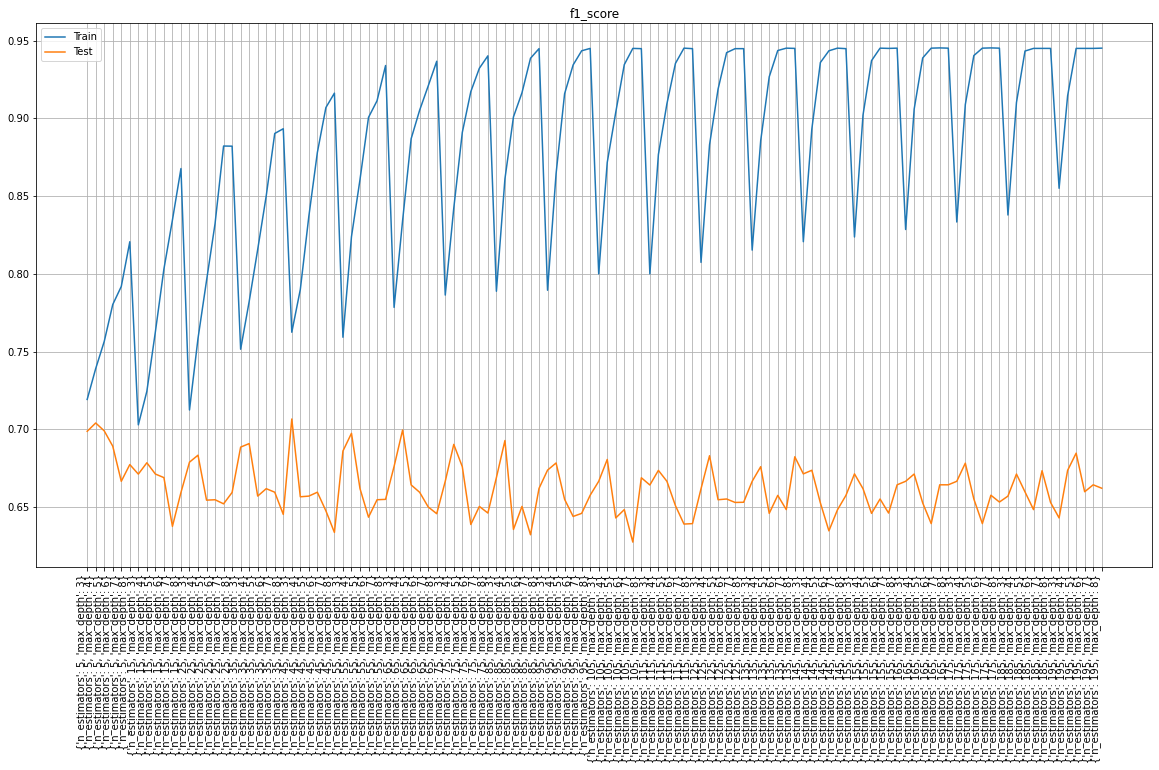

In [33]:
env_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
env_model, env_training, env_score, env_param = optimize(df[environmental_cols + ['target']], 0.3, model_constructor, env_params, plot=True)

In [34]:
print(environmental_cols)
env_score

['chol', 'smoker', 'smoker_cigs_per_day', 'smoker_years', 'fasting_blood_sugar']


{'f1_score': 0.7067137809187279,
 'accuracy_score': 0.6925925925925925,
 'precision_score': 0.7352941176470589,
 'recall_score': 0.6802721088435374}

Training models...: 100%|██████████| 120/120 [00:16<00:00,  7.29it/s]


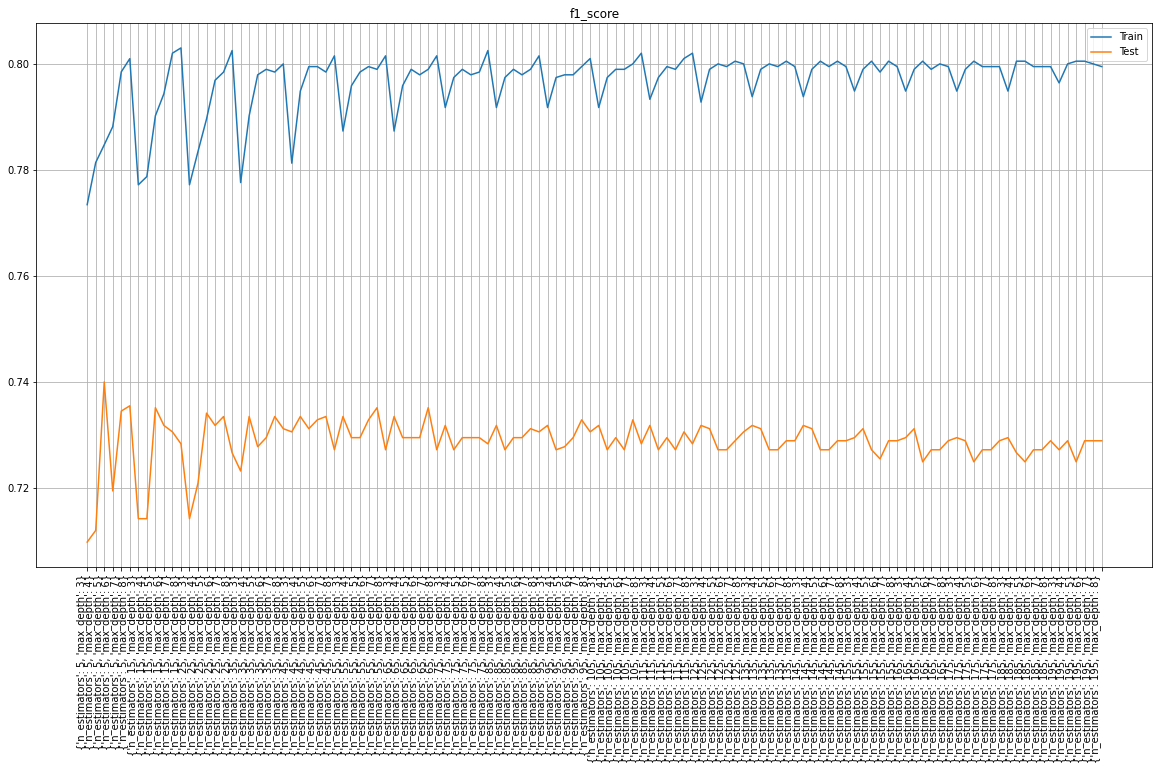

In [35]:
gen_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
gen_model, gen_training, gen_score, gen_param = optimize(df[genetic_cols + ['target']], 0.3, model_constructor, gen_params, plot=True)

In [36]:
print(genetic_cols)
gen_score

['sex_F', 'sex_M', 'age', 'heart_disease_family']


{'f1_score': 0.7400611620795107,
 'accuracy_score': 0.6851851851851852,
 'precision_score': 0.6505376344086021,
 'recall_score': 0.8581560283687943}

                   genetic  environmental
f1_score         74.006116      70.671378
accuracy_score   68.518519      69.259259
precision_score  65.053763      73.529412
recall_score     85.815603      68.027211


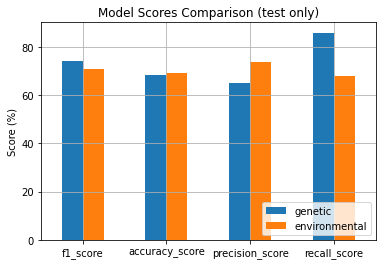

In [39]:
performance_df = pd.DataFrame([gen_score, env_score], index=['genetic', 'environmental']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.xticks(rotation=0)
plt.grid('on')
plt.ylabel('Score (%)')
plt.legend(loc=4)
plt.savefig('data/results/genetic_vs_env_model_scores.png')

# Question 3
Is there a simple or low-cost way to evaluate one's own risk of heart attack?

Training models...: 100%|██████████| 120/120 [00:33<00:00,  3.54it/s]


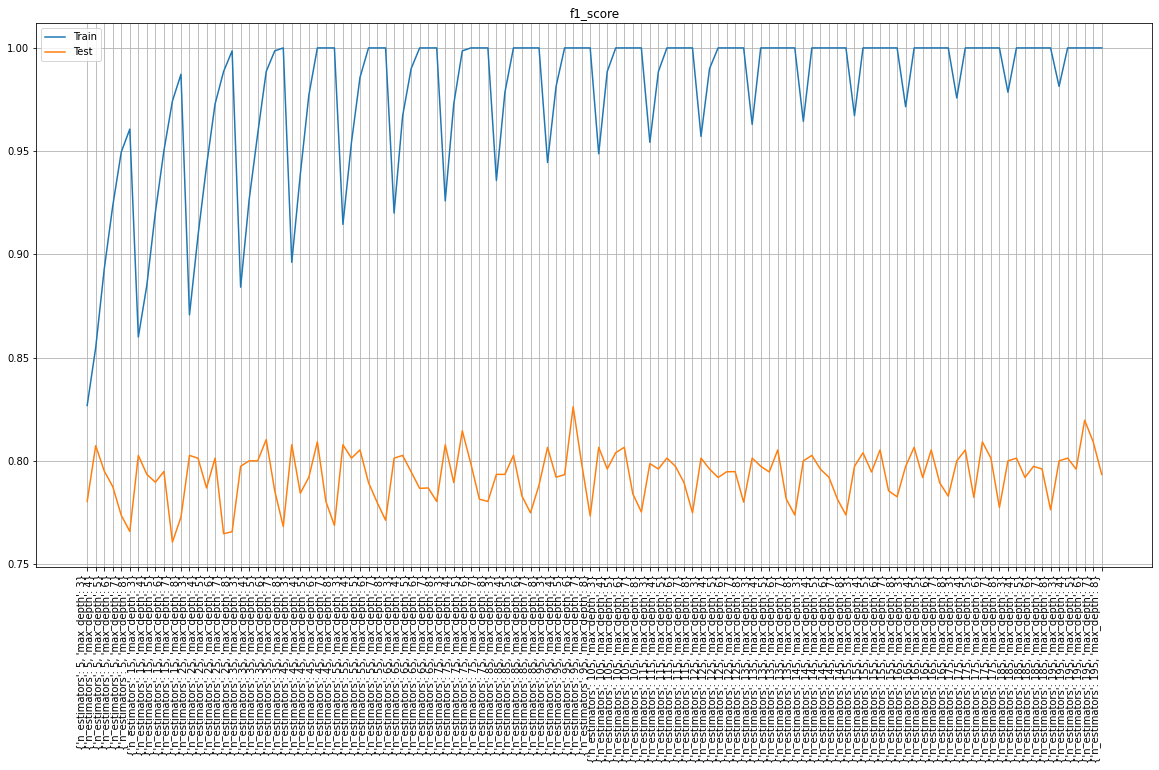

In [38]:
cheap_cols = list(types[types.feature_type.isin(['CT', 'H', 'G', 'E'])].feature)
cheap_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
cheap_model, cheap_training, cheap_score, cheap_param = optimize(df[cheap_cols + ['target']], 0.3, model_constructor, cheap_params, plot=True)

                   genetic  environmental      cheap
f1_score         74.006116      70.671378  82.622951
accuracy_score   68.518519      69.259259  80.370370
precision_score  65.053763      73.529412  79.746835
recall_score     85.815603      68.027211  85.714286


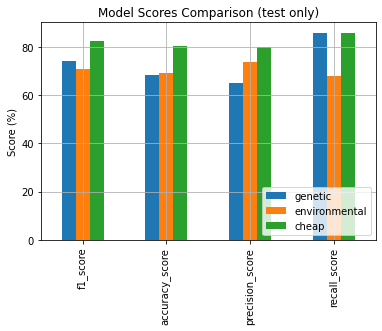

In [43]:
performance_df = pd.DataFrame([gen_score, env_score, cheap_score], index=['genetic', 'environmental', 'cheap']).T
print(performance_df * 100)
(performance_df * 100).plot.bar()
plt.title('Model Scores Comparison (test only)')
plt.ylabel('Score (%)')
plt.grid('on')
plt.legend(loc=4)

In [44]:
cheap_cols

['sex_F',
 'sex_M',
 'cp_type_atypical_angina',
 'cp_type_no_pain',
 'cp_type_non_anginal',
 'cp_type_typical_angina',
 'age',
 'blood_press_s_rest',
 'chol',
 'smoker',
 'smoker_cigs_per_day',
 'smoker_years',
 'fasting_blood_sugar',
 'heart_disease_family',
 'heart_rate_peak',
 'heart_rate_rest',
 'ex_angina']